In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import json

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# For data vasualisation, source: https://www.kaggle.com/code/alexisbcook/hello-seaborn
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/ODET_PA.json
/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/BOL_PA.json
/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/UMG_AMS.json
/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/VIV_PA.json


In [2]:
# Load the JSON data from the file
with open('/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/BOL_PA.json') as json_file:
    data = json.load(json_file)

bollore_data = data["Time Series (Daily)"]

df = pd.DataFrame(bollore_data)
df = df.transpose()



print(df)

            1. open  2. high   3. low 4. close 5. volume
2024-01-26   5.9250   6.0200   5.9200   5.9700    701693
2024-01-25   5.8500   5.9650   5.8500   5.9000    950562
2024-01-24   5.7200   5.8500   5.7200   5.8400    634590
2024-01-23   5.7750   5.7750   5.7000   5.7000    515673
2024-01-22   5.6550   5.7650   5.6550   5.7600    550502
...             ...      ...      ...      ...       ...
2005-01-07  59.1000  59.2000  58.8000  58.8000   1172700
2005-01-06  58.8500  59.5000  58.6500  59.0000    372900
2005-01-05  59.4500  59.4500  58.6500  59.0000    407500
2005-01-04  59.4000  59.9000  59.4000  59.5000   1711700
2005-01-03  60.4500  60.4500  59.4500  59.5000    123100

[4884 rows x 5 columns]


In [3]:
# Function to load data and reformat it as a pandas df
# Originally only used data from '2021-09-21' - (UMG IPO) 

def load_timeseries_as_df(ticker="BOL_PA", start_date='2018-09-21'): #old date = '2021-09-21' -> 1st trading day of UMG
    with open(f'/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/{ticker}.json') as json_file:
        data = json.load(json_file)

    timeseries_data = data["Time Series (Daily)"]

    df = pd.DataFrame(timeseries_data)
    df = df.transpose()
    
    # Backfill to start date with zeros
    date_range = pd.date_range(start=start_date, end=df.index.min(), freq='D')
    zero_df = pd.DataFrame(index=date_range, columns=df.columns).fillna(0)[::-1]
    df = pd.concat([df, zero_df])  
    
    # filter dates to relevant timeperiod
    df.index = pd.to_datetime(df.index)
    start_date = pd.to_datetime(start_date)
    df = df[df.index >= start_date]
            
    return df   

In [4]:
bol_df = load_timeseries_as_df(ticker="BOL_PA")
odet_df = load_timeseries_as_df(ticker="ODET_PA")
umg_df = load_timeseries_as_df(ticker="UMG_AMS")
viv_df = load_timeseries_as_df(ticker="VIV_PA")

print(bol_df)
print(umg_df) # need to extend data back in time to avoid effors (NaN...)

           1. open 2. high  3. low 4. close 5. volume
2024-01-26  5.9250  6.0200  5.9200   5.9700    701693
2024-01-25  5.8500  5.9650  5.8500   5.9000    950562
2024-01-24  5.7200  5.8500  5.7200   5.8400    634590
2024-01-23  5.7750  5.7750  5.7000   5.7000    515673
2024-01-22  5.6550  5.7650  5.6550   5.7600    550502
...            ...     ...     ...      ...       ...
2018-09-27  3.7300  3.7700  3.7080   3.7600   1072976
2018-09-26  3.7720  3.7720  3.7200   3.7480   1590962
2018-09-25  3.7580  3.7860  3.7360   3.7760   1230122
2018-09-24  3.7380  3.7760  3.7300   3.7640   1219877
2018-09-21  3.7560  3.7900  3.7420   3.7740   3390898

[1371 rows x 5 columns]
            1. open  2. high   3. low 4. close 5. volume
2024-01-26  27.5900  27.8600  27.5900  27.7500   1215343
2024-01-25  27.4500  27.8600  27.2300  27.8000   1180513
2024-01-24  26.9000  27.5200  26.9000  27.4700   1155035
2024-01-23  27.7200  27.7400  27.2200  27.2800    967627
2024-01-22  27.2100  27.7500  27.1500  27.

In [5]:
#Valuation logic (classes)
class Company:   
    def __init__(self, name, shares_outstanding, shareprice, currency='€'):
        self.name = name
        self.shares_outstanding = shares_outstanding
        self.shareprice = shareprice
        self.currency = currency

        #initialising values
        self.assets = []
        self.value = 0  
        self.discount_to_value_percent = 0
        self.outputs = {'assets': []}

        #updates .outputs with formatted values
        self.update_outputs()
     
    def market_cap(self, to_string=False):
        mkt_cap = self.shares_outstanding * self.shareprice
        if to_string:
            mkt_cap = Company.large_number_to_string(mkt_cap)
        return mkt_cap
    
    def asign_asset(self, asset, value='optional', is_company_object=False, ownership_fraction=1):
        if is_company_object:
            value_of_asset = asset.market_cap() * ownership_fraction
            name_of_asset = asset.name
        else:
            value_of_asset = value
            name_of_asset = asset
        
        self.assets += [{
            'name': name_of_asset,
            'ownership_percentage': ownership_fraction,
            'value': value_of_asset
            }]
        self.outputs['assets'] += [{
            'name': name_of_asset,
            'ownership_percentage': Company.fraction_to_percentage_string(ownership_fraction),
            'value': Company.large_number_to_string(value_of_asset)
            }]    
        self.value += value_of_asset
        self.discount_to_value_percent = Company.fraction_to_percentage_string(1 - (self.market_cap() / self.value))        
        self.update_outputs()

    def update_outputs(self):
        #should change this to use add_output! so that it overwrites old values
        new_outputs = {
            'name': self.name,
            'title': str(self),
            'market_cap': self.market_cap(to_string=True),
            'shares_outstanding': Company.large_number_to_string(self.shares_outstanding),
            'value': Company.large_number_to_string(self.value),
            'currency': self.currency,
            'share_price': self.shareprice
        }
        self.add_output(new_outputs)

    def add_output(self, new_outputs):
        self.outputs.update(new_outputs)

    def __str__(self):
        return f'{self.name} (mkt cap {self.market_cap(to_string=True)} @ {self.shareprice} per share)'
    
    @staticmethod
    def large_number_to_string(value):
        if value > 1000000000:
            value = f"{str(round(value/1000000000,1))}B"
        else:
            value = f"{str(int(round(value/1000000,0)))}M"
        return value
    
    @staticmethod
    def fraction_to_percentage_string(value):
        percentage_string = ''
        if value > 0.10:
            percentage_string = f'{int(round(value * 100, 0))}%'
        else:
            percentage_string = f'{round(value * 100, 1)}%'
        return percentage_string

class CircularOwnership:

    def __init__(self, company_1, company_1_outside_ownership, company_2, company_2_outside_ownership):
        # assumes all shares not held by outside owners are cross-held
        self.company_1 = company_1
        self.company_2 = company_2
        self.companies = [company_1, company_2]
        self.company_1_outside_ownership = company_1_outside_ownership
        self.company_2_outside_ownership = company_2_outside_ownership
        self.company_1_owned_by_company_2 = 1 - company_1_outside_ownership
        self.company_2_owned_by_company_1 = 1 - company_2_outside_ownership
        self.unassigned_assets_from_company_1 = company_1.value
        self.unassigned_assets_from_company_2 = company_2.value

        #initialising values
        self.assets_owned_by_company_1_outside_shareholders = 0
        self.assets_owned_by_company_2_outside_shareholders = 0
        self.proportion_of_assets_owned_by_company_1_outside_shareholders = 0
        self.proportion_of_assets_owned_by_company_2_outside_shareholders = 0

        self.distribution_of_assets_iterative()
        self.update_outputs_of_subsidiaries()

    # def distribution_of_assets_analytical(self):
    #     """
    #     - analytical solution - only for a simplified case where company_1 owns all assets
    #     """
    #     self.proportion_of_assets_owned_by_company_1_outside_shareholders = self.company_1_outside_ownership / (1 - (self.company_1_owned_by_company_2 * self.company_2_owned_by_company_1))

    #     self.proportion_of_assets_owned_by_company_2_outside_shareholders = (
    #         self.company_2_outside_ownership * self.company_1_owned_by_company_2
    #         / (1 - (self.company_2_owned_by_company_1 * self.company_1_owned_by_company_2))
    #     )

    #     print(f'Proportion Of Assets Owned By {self.company_1.name} Outside Shareholders', self.proportion_of_assets_owned_by_company_1_outside_shareholders, f'Proportion Of Assets Owned By {self.company_2.name} Outside Shareholders', self.proportion_of_assets_owned_by_company_2_outside_shareholders)

    def distribution_of_assets_iterative(self):
        total_assets = self.unassigned_assets_from_company_1 + self.unassigned_assets_from_company_2 + self.assets_owned_by_company_1_outside_shareholders + self.assets_owned_by_company_2_outside_shareholders

        while (self.unassigned_assets_from_company_1 + self.unassigned_assets_from_company_2) > 0.1:
            #section 1 of cycle
            self.assets_owned_by_company_1_outside_shareholders += self.unassigned_assets_from_company_1 * self.company_1_outside_ownership
            self.unassigned_assets_from_company_1 -= self.unassigned_assets_from_company_1 * self.company_1_outside_ownership
            self.assets_owned_by_company_2_outside_shareholders += self.unassigned_assets_from_company_2 * self.company_2_outside_ownership
            self.unassigned_assets_from_company_2 -= self.unassigned_assets_from_company_2 * self.company_2_outside_ownership
            # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.unassigned_assets_from_company_1}, {self.assets_owned_by_company_2_outside_shareholders}, {self.unassigned_assets_from_company_2}')

            #section 2 of cycle
            self.assets_owned_by_company_1_outside_shareholders += self.unassigned_assets_from_company_2 * self.company_1_outside_ownership
            self.unassigned_assets_from_company_2 -= self.unassigned_assets_from_company_2 * self.company_1_outside_ownership
            self.assets_owned_by_company_2_outside_shareholders += self.unassigned_assets_from_company_1 * self.company_2_outside_ownership
            self.unassigned_assets_from_company_1 -= self.unassigned_assets_from_company_1 * self.company_2_outside_ownership
            # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.unassigned_assets_from_company_1}, {self.assets_owned_by_company_2_outside_shareholders}, {self.unassigned_assets_from_company_2}')

        self.proportion_of_assets_owned_by_company_1_outside_shareholders = self.assets_owned_by_company_1_outside_shareholders / total_assets
        self.proportion_of_assets_owned_by_company_2_outside_shareholders = self.assets_owned_by_company_2_outside_shareholders / total_assets

        # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.assets_owned_by_company_2_outside_shareholders}')

    def update_outputs_of_subsidiaries(self):
        add_to_company_1_ouputs = {
            'outside_shares': f'{Company.fraction_to_percentage_string(self.company_1_outside_ownership)}',
            'cross_holding_description': f'Owns {Company.fraction_to_percentage_string(self.company_2_owned_by_company_1)} of {self.company_2.name} →',
            'economic_ownership_percentage': f'{Company.fraction_to_percentage_string(self.proportion_of_assets_owned_by_company_1_outside_shareholders)}',
            'value_of_economic_ownership': f'{Company.large_number_to_string(self.assets_owned_by_company_1_outside_shareholders)}',
            'market_cap_of_outside_shares': f'{Company.large_number_to_string(self.company_1.market_cap() * self.company_1_outside_ownership)}',
            'discount': f'-{Company.fraction_to_percentage_string(1 - (self.company_1.market_cap() * self.company_1_outside_ownership) /self.assets_owned_by_company_1_outside_shareholders)}',
            'discount_num': -(1 - (self.company_1.market_cap() * self.company_1_outside_ownership) /self.assets_owned_by_company_1_outside_shareholders)
        }
        add_to_company_2_ouputs = {
            'outside_shares': f'{Company.fraction_to_percentage_string(self.company_2_outside_ownership)}',
            'cross_holding_description': f'← Owns {Company.fraction_to_percentage_string(self.company_1_owned_by_company_2)} of {self.company_1.name}',
            'economic_ownership_percentage': f'{Company.fraction_to_percentage_string(self.proportion_of_assets_owned_by_company_2_outside_shareholders)}',
            'value_of_economic_ownership': f'{Company.large_number_to_string(self.assets_owned_by_company_2_outside_shareholders)}',
            'market_cap_of_outside_shares': f'{Company.large_number_to_string(self.company_2.market_cap() * self.company_2_outside_ownership)}',
            'discount': f'-{Company.fraction_to_percentage_string(1 - (self.company_2.market_cap() * self.company_2_outside_ownership) /self.assets_owned_by_company_2_outside_shareholders)}',
            'discount_num': -(1 - (self.company_2.market_cap() * self.company_2_outside_ownership) /self.assets_owned_by_company_2_outside_shareholders)

        }
        
        self.company_1.add_output(add_to_company_1_ouputs)
        self.company_2.add_output(add_to_company_2_ouputs)
        

    def __str__(self):
        return f'{self.company_1} owns {round(self.company_2_owned_by_company_1 * 100,3)}% of {self.company_2} and {self.company_2} owns {round(self.company_1_owned_by_company_2 * 100,3)}% of {self.company_1}'


In [6]:
# assigns assets, 
def main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    # Bollore 'galaxy'
    bollore = Company('Bolloré SE', shares_outstanding=(2902650243 - 99.1 * 10 ** 6) , shareprice=bollore_shareprice)
    umg = Company('Universal Music Group', shares_outstanding=1.81 * 10 ** 9, shareprice=umg_shareprice)
    odet = Company("Compagnie de l'Odet", shares_outstanding=6590000, shareprice=odet_shareprice)
    vivendi = Company("Vivendi", shares_outstanding=1139051437, shareprice=vivindi_shareprice)

    # Asign Assets
    bollore.asign_asset(asset=umg, is_company_object=True, ownership_fraction=0.1810) # was 17.7%, cash flow statement implies they've been buying
    odet.asign_asset(asset=umg, is_company_object=True, ownership_fraction=0.0033)
    bollore.asign_asset(asset=vivendi, is_company_object=True, ownership_fraction=0.29)
    odet.asign_asset(asset=vivendi, is_company_object=True, ownership_fraction=0.005)
    bollore.asign_asset('Cash', (1.415*10**9)) #source - 'liquidity'
    bollore.asign_asset('Expected proceeds from sale of Bolloré logistics', 4.65*10**9) # 4.65B euros, prior to net cash/debt

    bollore_odet_group = CircularOwnership(company_1=bollore, company_1_outside_ownership=0.292, company_2=odet, company_2_outside_ownership=0.16)
    
    return bollore, umg, odet, vivendi, bollore_odet_group

def odet_discount(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    bollore, umg, odet, vivendi, bollore_odet_group = main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice)
    return odet.outputs["discount_num"]

def bollore_discount(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    bollore, umg, odet, vivendi, bollore_odet_group = main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice)
    return bollore.outputs["discount_num"]

In [7]:
# main_df = pd.concat([bol_df, odet_df, umg_df, viv_df], axis=1)
half1_df = pd.merge(bol_df, odet_df, left_index=True, right_index=True, suffixes=('_bol', '_odet'))
half2_df = pd.merge(umg_df, viv_df, left_index=True, right_index=True, suffixes=('_umg', '_viv'))
main_df = pd.merge(half1_df, half2_df, left_index=True, right_index=True)

print(main_df.head())

main_df = main_df.apply(pd.to_numeric, errors='coerce')
main_df.info()

           1. open_bol 2. high_bol 3. low_bol 4. close_bol 5. volume_bol  \
2018-09-21      3.7560      3.7900     3.7420       3.7740       3390898   
2018-09-24      3.7380      3.7760     3.7300       3.7640       1219877   
2018-09-25      3.7580      3.7860     3.7360       3.7760       1230122   
2018-09-26      3.7720      3.7720     3.7200       3.7480       1590962   
2018-09-27      3.7300      3.7700     3.7080       3.7600       1072976   

           1. open_odet 2. high_odet 3. low_odet 4. close_odet 5. volume_odet  \
2018-09-21     816.0000     828.0000    816.0000      820.0000             27   
2018-09-24     820.0000     824.0000    818.0000      822.0000             39   
2018-09-25     824.0000     830.0000    820.0000      826.0000             40   
2018-09-26     828.0000     830.0000    818.0000      820.0000             67   
2018-09-27     820.0000     824.0000    810.0000      822.0000             76   

           1. open_umg 2. high_umg 3. low_umg 4. close_u

In [8]:
# Calculate the valuation discount for each of Odet & Bollore

# choose what time of day to pick data from
time_price = "4. close"

# Can use apply method to apply the function to each row:
main_df["discount_odet"] = main_df.apply(lambda row: odet_discount(row[time_price+"_bol"], row[time_price+"_umg"], row[time_price+"_odet"], row[time_price+"_viv"]), axis=1)
main_df["discount_bol"] = main_df.apply(lambda row: bollore_discount(row[time_price+"_bol"], row[time_price+"_umg"], row[time_price+"_odet"], row[time_price+"_viv"]), axis=1)
main_df["discount_ratio"] = 1 - main_df["discount_odet"] / main_df["discount_bol"]

# although mainly focussed on discount, Odet/Bollore price ratio is probably a useful feature too?
normalisation_factor = main_df[time_price + "_odet"].mean() / main_df[time_price + "_bol"].mean()
main_df["price_ratio"] = (main_df[time_price + "_odet"] / main_df[time_price + "_bol"]) / normalisation_factor

print(main_df.head())

/tmp/ipykernel_18/3926679014.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  self.discount_to_value_percent = Company.fraction_to_percentage_string(1 - (self.market_cap() / self.value))
/tmp/ipykernel_18/3926679014.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  self.discount_to_value_percent = Company.fraction_to_percentage_string(1 - (self.market_cap() / self.value))


            1. open_bol  2. high_bol  3. low_bol  4. close_bol  5. volume_bol  \
2018-09-21        3.756        3.790       3.742         3.774        3390898   
2018-09-24        3.738        3.776       3.730         3.764        1219877   
2018-09-25        3.758        3.786       3.736         3.776        1230122   
2018-09-26        3.772        3.772       3.720         3.748        1590962   
2018-09-27        3.730        3.770       3.708         3.760        1072976   

            1. open_odet  2. high_odet  3. low_odet  4. close_odet  \
2018-09-21         816.0         828.0        816.0          820.0   
2018-09-24         820.0         824.0        818.0          822.0   
2018-09-25         824.0         830.0        820.0          826.0   
2018-09-26         828.0         830.0        818.0          820.0   
2018-09-27         820.0         824.0        810.0          822.0   

            5. volume_odet  ...  5. volume_umg  1. open_viv  2. high_viv  \
2018-09-21      

<Axes: >

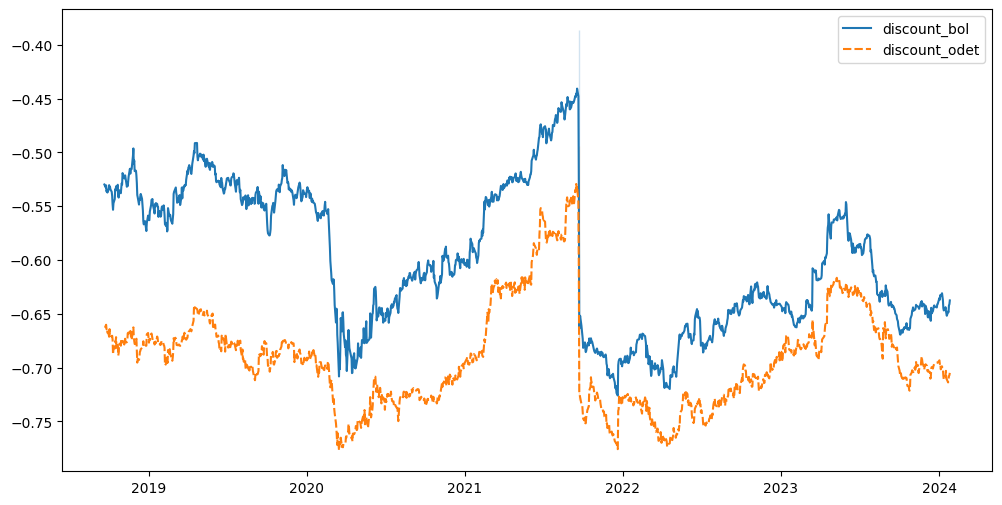

In [9]:
# Data visualisation, starting code - https://www.kaggle.com/code/alexisbcook/hello-seaborn
# Set the width and height of the figure
plt.figure(figsize=(12,6))

# Line chart showing how FIFA rankings evolved over time 
sns.lineplot(data=main_df[["discount_bol", "discount_odet"]])

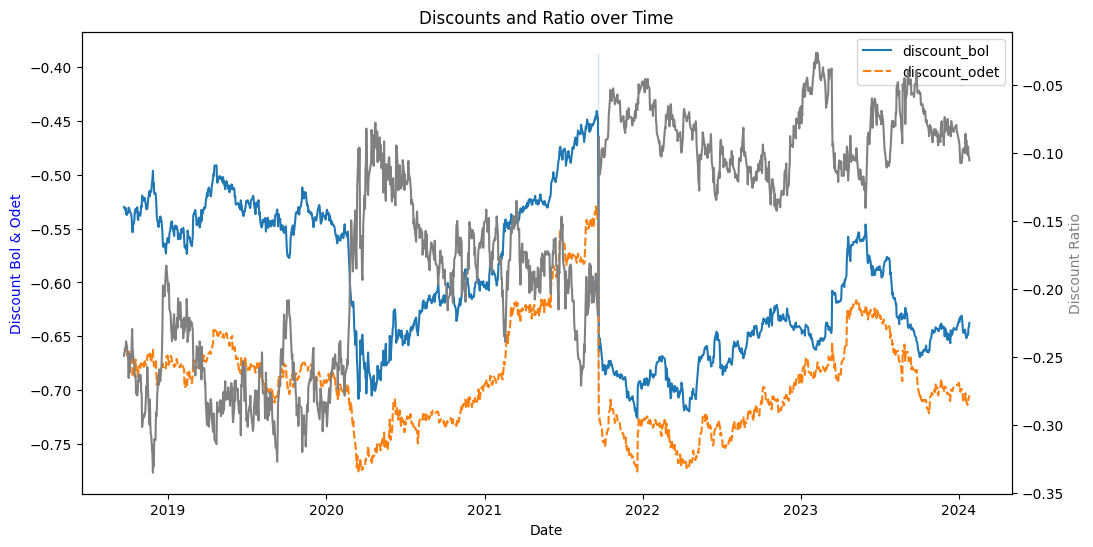

discount range: -0.026512152660705945 -0.3351893725138049
median & mean: -0.14006753022822882 -0.1585815645403872 standard deviation 0.07935914473329604


In [10]:
columns_to_plot = ["discount_bol", "discount_odet", "discount_ratio"]

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=main_df[columns_to_plot[:2]], ax=ax1)

ax2 = ax1.twinx()

sns.lineplot(data=main_df[columns_to_plot[2]], ax=ax2, color='grey')

ax1.set_xlabel('Date')
ax1.set_ylabel('Discount Bol & Odet', color='blue')
ax2.set_ylabel('Discount Ratio', color='grey')
plt.title('Discounts and Ratio over Time')

plt.show()

print("discount range:",main_df["discount_ratio"].max(), main_df["discount_ratio"].min())
print("median & mean:", main_df["discount_ratio"].median(), main_df["discount_ratio"].mean(),"standard deviation", main_df["discount_ratio"].std())

In [11]:
# generalised function for approach used below
def remove_columns_starting_with(start_df, prefixes_to_remove):
    columns_to_remove = [col for col in start_df.columns if any(col.startswith(prefix) for prefix in prefixes_to_remove)]
    return_df = start_df.drop(columns=columns_to_remove)
    return return_df

**Open/close/high/low shareprices had extremely close correlation to one another (>=0.99) & highly associated in PCA, so removed to simplify the analysis**

In [12]:
# Feature engineering (feature selection)
# Removing all columns for open/high/low price for now (so we can focus on closing price)
columns_to_remove = [col for col in main_df.columns if any(col.startswith(prefix) for prefix in ('1. open', '2. high', '3. low', '5. volume'))]
# if col.startswith('1. open') or col.startswith('2. high') ... would have been alternate approach

end_day_df = main_df.drop(columns=columns_to_remove)
#NOTE - open/close/high/low shareprices had extremely close correlation to one another (>=0.99) & highly associated in PCA, so removed to simplify the analysis

end_day_df.head()

,4. close_bol,4. close_odet,4. close_umg,4. close_viv,discount_odet,discount_bol,discount_ratio,price_ratio
2018-09-21,3.774,820.0,0.0,9.1165,-0.661926,-0.529814,-0.249354,0.909969
2018-09-24,3.764,822.0,0.0,9.1991,-0.662133,-0.532479,-0.243492,0.914612
2018-09-25,3.776,826.0,0.0,9.1784,-0.660230,-0.530633,-0.244231,0.916142
2018-09-26,3.748,820.0,0.0,9.3107,-0.664336,-0.536362,-0.238597,0.916282
2018-09-27,3.760,822.0,0.0,9.2983,-0.663364,-0.534667,-0.240706,0.915585


In [13]:
# Check Correlation Matrix:
correlation_matrix = end_day_df.corr() #main_df.corr()
correlation_matrix

#NOTE - open/close/high/low shareprices had extremely close correlation to one another (>=0.99) & highly associated in PCA, so removed to simplify the analysis

,4. close_bol,4. close_odet,4. close_umg,4. close_viv,discount_odet,discount_bol,discount_ratio,price_ratio
4. close_bol,1.000000,0.969926,0.803413,-0.007980,0.287630,-0.124170,0.491637,0.704635
4. close_odet,0.969926,1.000000,0.842406,-0.044853,0.258544,-0.239170,0.654393,0.853390
4. close_umg,0.803413,0.842406,1.000000,-0.213581,-0.294464,-0.682028,0.812770,0.756263
4. close_viv,-0.007980,-0.044853,-0.213581,1.000000,0.278042,0.286382,-0.207268,-0.063346
discount_odet,0.287630,0.258544,-0.294464,0.278042,1.000000,0.823435,-0.327987,0.137867
discount_bol,-0.124170,-0.239170,-0.682028,0.286382,0.823435,1.000000,-0.804339,-0.443852
discount_ratio,0.491637,0.654393,0.812770,-0.207268,-0.327987,-0.804339,1.000000,0.873029
price_ratio,0.704635,0.853390,0.756263,-0.063346,0.137867,-0.443852,0.873029,1.000000


<Axes: >

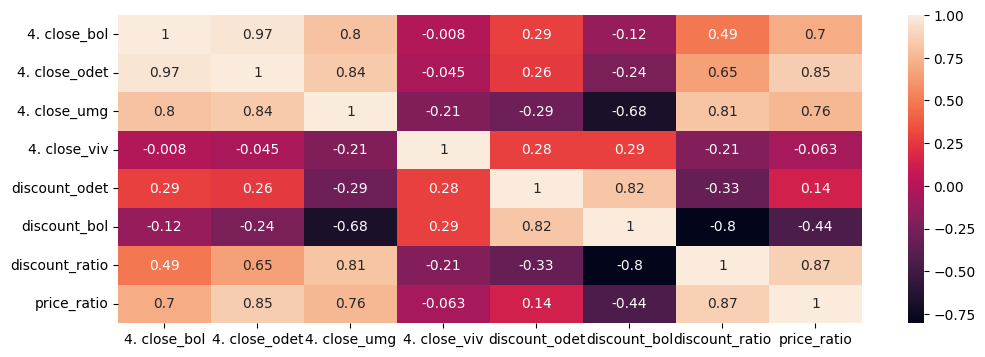

In [14]:
plt.figure(figsize=(12,4))
sns.heatmap(correlation_matrix, annot=True)

# Interesting observations
* Discount_ratio is most closely correlated with UMG stock price (surprising) & has limmited correlation with discount_odet (surprising).
* Otherwise discount_ratio shows some correlation with ODET price (not much with BOL), and some with discount_bol (but not much with discount_odet)
* Volumes don't seem to be closely correlated with anything significant & mostly correlate with one another.

In [15]:
# Target variable - goal is to figure out whether available information can provide good signals for trading the ODET / BOL pair.
# As a first attempt at a target variable I'm going to propose fractional profit/loss from buying ODET & selling BOL & holding for 60 days

# Shift the values of the desired column 60 days ahead
days_ahead = 120

dummy_df = pd.DataFrame()
dummy_df[f'price_{days_ahead}_days_ahead' + '_odet'] = main_df[time_price + "_odet"].shift(+ days_ahead)
dummy_df[f'price_{days_ahead}_days_ahead' + '_bol'] = main_df[time_price + "_bol"].shift(+ days_ahead)

# Calculates the fractional profit, from buying Odet and shorting Bollore for 60 days
main_df[f'trading_profit_{days_ahead}_days_frctn'] = (
    (( dummy_df[f'price_{days_ahead}_days_ahead' + '_odet'] - main_df[time_price + "_odet"])
    / main_df[time_price + "_odet"]
    ) - (
    ( dummy_df[f'price_{days_ahead}_days_ahead' + '_bol'] - main_df[time_price + "_bol"])
    / main_df[time_price + "_bol"]
    )) / 2

# number of rows=days_ahead of NaN need to be dropped for data to be useful for machine learning later (data wrangling)
main_df = main_df.dropna()

print(main_df.head())

            1. open_bol  2. high_bol  3. low_bol  4. close_bol  5. volume_bol  \
2019-03-14        3.900        3.914       3.880         3.912        1001958   
2019-03-15        3.872        3.940       3.832         3.832        2801940   
2019-03-18        3.830        3.898       3.830         3.896        1148956   
2019-03-19        3.880        3.982       3.880         3.982         948008   
2019-03-20        3.972        3.986       3.864         3.884        1060371   

            1. open_odet  2. high_odet  3. low_odet  4. close_odet  \
2019-03-14         822.0         826.0        822.0          824.0   
2019-03-15         830.0         830.0        820.0          822.0   
2019-03-18         824.0         830.0        824.0          828.0   
2019-03-19         812.0         838.0        812.0          838.0   
2019-03-20         834.0         836.0        832.0          836.0   

            5. volume_odet  ...  1. open_viv  2. high_viv  3. low_viv  \
2019-03-14         

In [16]:
# PCA:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis

# 1st select and standardise data:

X = main_df.copy().drop(columns=columns_to_remove) #removes 'wrong' time of day
# X = remove_columns_starting_with(start_df=X, prefixes_to_remove=("5. volume"))

y = X.pop(f'trading_profit_{days_ahead}_days_frctn')

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [17]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)


In [18]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
4. close_bol,-0.369429,0.354835,-0.069591,-0.463447,-0.259725,-0.088434,-0.665348,0.004685
4. close_odet,-0.414149,0.316032,-0.045579,-0.159242,0.000181,-0.583858,0.592394,0.096682
4. close_umg,-0.456635,-0.042731,0.049721,-0.381925,0.244488,0.693244,0.303336,-0.094586
4. close_viv,0.156348,0.281772,0.943299,-0.072755,-0.020459,0.009060,0.022203,-0.007741
discount_odet,0.074949,0.624853,-0.177486,0.343649,-0.162215,0.380592,0.087253,0.524947
discount_bol,0.300851,0.497554,-0.210394,-0.021554,-0.011551,0.076451,0.124237,-0.771872
discount_ratio,-0.430428,-0.166289,0.135403,0.446396,-0.683262,0.110827,0.075147,-0.291033
price_ratio,-0.421482,0.165353,0.081814,0.539324,0.615676,-0.087420,-0.291856,-0.159902


<Axes: >

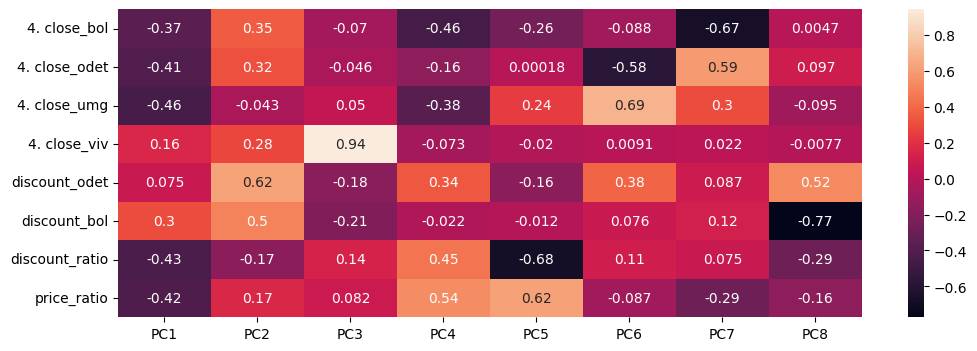

In [19]:
plt.figure(figsize=(12,4))
sns.heatmap(loadings, annot=True)

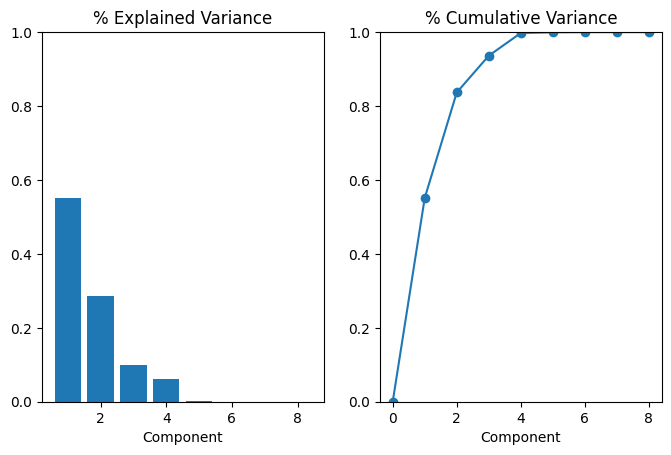

In [20]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
# Look at explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);

# Initial attempts at random forest to explore which variables are important for predicting whether trades profitable/unprofitable
example code source = https://www.kaggle.com/code/alexisbcook/machine-learning-competitions/tutorial

In [21]:
##### Import helpful libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split # Not appropriate for this temporal dataset

# Need to split as timeseries:
from sklearn.model_selection import TimeSeriesSplit

# Separate the target
# I've already defined X and y for the PCA model, will use those for now.

#choose whether to include synthetic features related to price & discount
remove_features = False
if (remove_features):
    X = remove_columns_starting_with(X, ("price", "discount")) # test model without synthetic features

# new synthetic features:
add_upper_lower_thresholds = True
if (add_upper_lower_thresholds):
#     threshold_upper = X["discount_ratio"].median() - X["discount_ratio"].std()
#     threshold_lower = X["discount_ratio"].median() + X["discount_ratio"].std()
    threshold_upper = -0.11
    threshold_lower = -0.06


    X['discount_wide'] = np.where(X['discount_ratio'] < threshold_upper, 1, 0)
    X['discount_narrow'] = np.where(X['discount_ratio'] > threshold_lower, 1, 0)


# Doesn't appear to help the model - set to False
add_thresholds_price_ratio = False
if (add_thresholds_price_ratio):
    price_ratio_upper = 1.05
    price_ratio_lower = 0.95
    
    X['price_ratio_high'] = np.where(X['price_ratio'] > price_ratio_upper, 1, 0)
    X['price_ratio_low'] = np.where(X['price_ratio'] < price_ratio_lower, 1, 0)
    
    
# Instead:
# Create TimeSeriesSplit object - n_splits: number "folds"
tscv = TimeSeriesSplit(n_splits=10)

# Iterate over the splits
for train_index, val_index in tscv.split(X):
    train_X, val_X = X.iloc[train_index], X.iloc[val_index]
    
for train_index, val_index in tscv.split(y):
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
# .fit model initially returned error - input y contained NaN (before I ran main_df.dropna() )
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print(f'Validation MAE for Random Forest Model (%): {(rf_val_mae * 100).round(3)}')
print("Average absolute change (trading) in validation set",(val_y.abs().mean() * 100).round(3), "%")

print(val_X.head())
print(X["discount_narrow"].sum())

Validation MAE for Random Forest Model (%): 3.279
Average absolute change (trading) in validation set 2.392 %
            4. close_bol  4. close_odet  4. close_umg  4. close_viv  \
2023-08-18         5.340         1430.0         23.02         8.030   
2023-08-21         5.355         1414.0         23.02         8.070   
2023-08-22         5.385         1400.0         23.02         8.220   
2023-08-23         5.315         1372.0         23.14         8.220   
2023-08-24         5.305         1350.0         22.88         8.176   

            discount_odet  discount_bol  discount_ratio  price_ratio  \
2023-08-18      -0.673421     -0.630328       -0.068366     1.121527   
2023-08-21      -0.677339     -0.629592       -0.075838     1.105872   
2023-08-22      -0.681512     -0.628653       -0.084082     1.088823   
2023-08-23      -0.688639     -0.634366       -0.085554     1.081099   
2023-08-24      -0.691735     -0.632804       -0.093127     1.065769   

            discount_wide  dis

* **Temporal data, with consecutive time points highly likely to be correlated. A simple random split using train_test_split doesn't appear to be suitable.**
* **Swapping trading time perdiod from 60 -> 120 days seems to reduce MAE consdierably**

# ALL VALUES SHOULD BE HALVED (forgot to divide profit by 2 initially)
**For trading time = 120 days, with just stock prices (no synthetic variables), TimeSeriesSplit(n_splits=10)**
* Validation MAE for Random Forest Model (%): 3.577 --- (3.445% with volumes)
* Average absolute change (trading) in validation set 4.615 %

**Adding synthetic variable: "price_ratio"**
* Validation MAE for Random Forest Model (%): 2.699
* Average absolute change (trading) in validation set 4.615 %

**Adding only synthetic variables: "discount_odet", "discount_bol", "discount_ratio" (NOT "price_ratio)**
* Validation MAE for Random Forest Model (%): 2.718
* Average absolute change (trading) in validation set 4.615 %

**Adding synthetic variables: "discount_odet", "discount_bol", "discount_ratio", "price_ratio"**
* Validation MAE for Random Forest Model (%): 2.357
* Average absolute change (trading) in validation set 4.615 %

**Adding further synthetic variables (derived from discount ratio): "discount_wide", "discount_narrow"**
* Validation MAE for Random Forest Model (%): 2.268 --- (2.272% with volumes)
* Average absolute change (trading) in validation set 4.615 %

**Adding further synthetic variables (derived from price ratio): "price_ratio_high", "price_ratio_low"**
* Validation MAE for Random Forest Model (%): 2.422     //-> significantly worse
* Average absolute change (trading) in validation set 4.615 %

*overall, volumes don't appear to make much difference either way, so have chosen to remove for improved interpretability*


In [22]:
print("trading profit, max:",y.max(),"mean:", y.mean(),"std:", y.std())
print("------------------------")
dummy_df_2=pd.concat([X, y],axis=1)

def average_profit(discount_description, value, df=dummy_df_2):
    df = df[df["discount_" + discount_description] == value]
    return df["trading_profit_120_days_frctn"].mean()
    
print(average_profit("wide", 1), average_profit("narrow", 1))
print(average_profit("wide", 0), average_profit("narrow", 0))

trading profit, max: 0.09051986671921469 mean: -0.009021302648059875 std: 0.03857912078169152
------------------------
-0.00524285298436412 -0.046657585450586715
-0.01443904078452636 -0.005465118446246317


<Axes: >

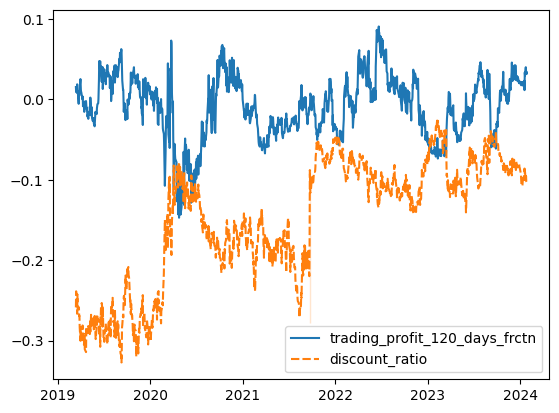

In [23]:
sns.lineplot(data=dummy_df_2[["trading_profit_120_days_frctn","discount_ratio"]])

<Axes: >

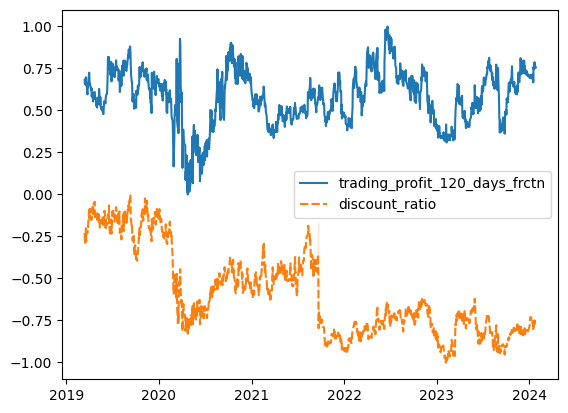

In [24]:
def normalise(df):
    return (df - df.min()) / (df.max() - df.min())


dummy_df_3 = normalise(main_df.copy())
dummy_df_3["discount_ratio"] = -dummy_df_3["discount_ratio"]
sns.lineplot(data=dummy_df_3[["trading_profit_120_days_frctn","discount_ratio"]])

In [25]:
# Tensor flow & keras - starting code from: https://www.kaggle.com/code/ryanholbrook/binary-classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from tensorflow import keras
from tensorflow.keras import layers

# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


/tmp/ipykernel_18/637921140.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [26]:
# Engineer a new binary feature determining whether or not to trade
y_new = y.apply(lambda x: 1 if x >= 0.00 else 0)

# Instead:
# Create TimeSeriesSplit object - n_splits: number "folds"
tscv = TimeSeriesSplit(n_splits=7)

# Iterate over the splits
for train_index, val_index in tscv.split(X):
    train_X, val_X = X.iloc[train_index], X.iloc[val_index]
    
for train_index, val_index in tscv.split(y_new):
    train_y, val_y = y_new.iloc[train_index], y_new.iloc[val_index]

Epoch 1/300
11/11 [==============================] - 3s 38ms/step - loss: 0.6594 - binary_accuracy: 0.7059 - val_loss: 0.6626 - val_binary_accuracy: 0.7372
Epoch 2/300
11/11 [==============================] - 0s 9ms/step - loss: 0.5468 - binary_accuracy: 0.7543 - val_loss: 0.7026 - val_binary_accuracy: 0.2628
Epoch 3/300
11/11 [==============================] - 0s 9ms/step - loss: 0.4927 - binary_accuracy: 0.7644 - val_loss: 0.7246 - val_binary_accuracy: 0.2628
Epoch 4/300
11/11 [==============================] - 0s 10ms/step - loss: 0.4937 - binary_accuracy: 0.7781 - val_loss: 0.7566 - val_binary_accuracy: 0.2628
Epoch 5/300
11/11 [==============================] - 0s 11ms/step - loss: 0.4559 - binary_accuracy: 0.7854 - val_loss: 0.7999 - val_binary_accuracy: 0.2628
Epoch 6/300
11/11 [==============================] - 0s 9ms/step - loss: 0.4698 - binary_accuracy: 0.7872 - val_loss: 0.8206 - val_binary_accuracy: 0.2628
Epoch 7/300
11/11 [==============================] - 0s 11ms/step -

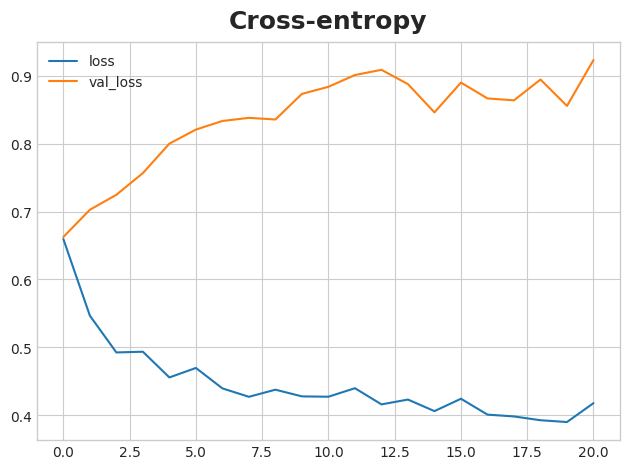

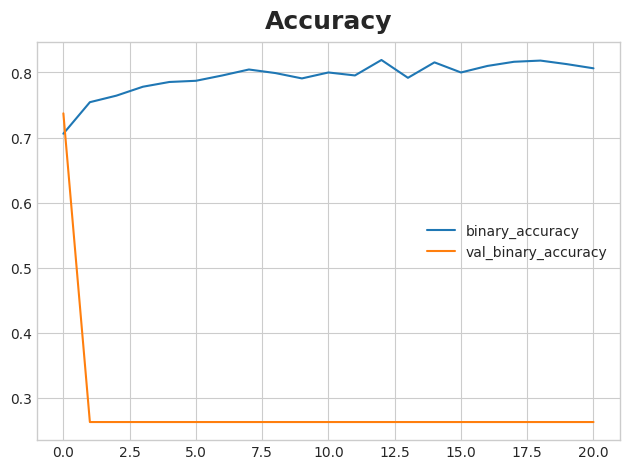

In [27]:
input_shape = [X.shape[1]]

activation_method="sigmoid"#"relu"#

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    #--------------------------
    layers.Dense(200, activation=activation_method),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    #--------------------------
    layers.Dense(200, activation=activation_method),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    #--------------------------
    layers.Dense(200, activation=activation_method),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    

    layers.Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.01,
    restore_best_weights=True,
)
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

#Checks
print("total +ves in val_sample:",val_y.sum())
print("total size of val_sample:",val_y.size)
print(y_new.sum())
print(y_new.size)
